<a href="https://colab.research.google.com/github/rafasuzuki/DataScience/blob/main/Detec%C3%A7%C3%A3o_de_Fraudes_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

Iremos abordar neste projeto uma grande preocupação das instituições financeiras, as fraudes em cartões de crédito. Cerca de 12,1 milhões de brasileiros já foram vítimas de crimes envolvendo algum tipo de fraude financeiro no último ano, o que se traduz em R$ 1,8 bilhão de prejuízo nos últimos 12 meses. 

<p align=center>
<img src="https://www.infomoney.com.br/wp-content/uploads/2019/06/cartao-de-credito-5.jpg?fit=900%2C644&quality=50&strip=all" width="60%"></p>

Dentre essas fraudes, aquelas que envolvem cartões de crédito são de grande relevância, pois a sua não detecção  implica em prejuízos tanto para o consumidor quanto para a instituição financeira.

 Além desses prejuízos, outro fator importante a ser considerado é a quantidade de falsos positivos, ou seja, quando o consumidor tenta realizar uma compra e tem seu cartão de crédito preventivamente bloqueado - o que sempre gera estresse e constrangimento. 

Com esse problema em evidência, as instituições financeiras vem investindo cada vez mais nas áreas de detecção de fraude por meio de Inteligência Artificial, representado uma grande oportunidade em Data Science.

Com grandes volumes de dados como base histórica, um algoritmo de *Machine Learning* um pouco melhor do que as anteriores já poderia apresentar uma economia de milhões de reais. E esse é o objetivo, o aprimoramento dos algoritmos refinando a detecção visando evitar cada vez mais transações fraudulentas.  

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="https://veja.abril.com.br/wp-content/uploads/2017/03/economia-cartao-de-credito-20150410-001.jpg" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor ou igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [2]:
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalar a biblioteca scikit-plot
!pip install -q scikit-plot

In [3]:
#importando pacotes necessários
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import pydotplus


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from IPython.display import Image


from imblearn.under_sampling import RandomUnderSampler

sns.set_style('dark')


In [4]:
# importando os dados para um dataframe

file_path = 'https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1'

df = pd.read_csv(file_path)

Agora que temos os dados importados dentro de uma estrutra de *Dataframe*, e não necessitando de ajustes para a exploração desses dados, podemos começar a preparar um modelo de *Machine Learning*.

## Análise Exploratória

Para começarmos a explorar nossos dados precisamos entender como nosso *dataset* está representado, para isso analisaremos as 5 primeiras entradas.

A partir disso podemos verificar que:


*   A transformação PCA deixou as *features* descaracterizadas (anônimas).

*   As colunas `Time` e `Amount` foram preservadas, mantendo seu valor original.

*   A coluna `Class` é a variável alvo, onde:

 *   **0**: representa uma transação normal.
 *   **1**: representa uma transação fraudulenta.
 







In [5]:
# ver as 5 primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Abaixo verificaremos o resumo estatístico, por meio do método `describe()`.
Aparentemente não temos nenhuma discrepância em nosso *Dataset*.

Em relação à variável `Amount`, nota-se que o valor médio de transações (considerando ambas as classes) é 88.34, mediana igual a 22.00 e desvio padrão de 250.12. Atingindo o valor máximo de 25691.16, a maioria das transações financeiras é composta em sua maioria por quantias menores - como esperado.


In [6]:
# ver o resumo estatístico
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


A qualidade do *Dataset* é diretamente ligado a quantidade de valores ausente. Abaixo, podemos verificar que nosso conjunto de dados está completo, sem valores ausentes.

In [7]:
# verificando se há valores ausentes
df.isnull().sum().max()

0

Como foi informado na descrição dos dados, as entradas referentes à transações fraudulentas representam 0,17% do total.

O gráfico de barras mostra a nítida discrepância dos valores, o que interfere no desempenho do modelo de *Machine Learning*. Com isso será necessário realizar um balanceamento dos dados antes de alimentar o nosso modelo de classificação.

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset.



[]

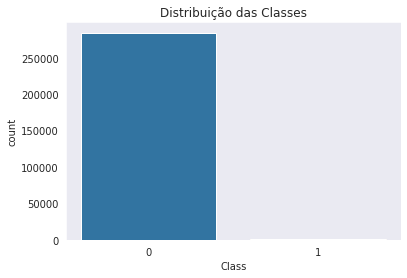

In [8]:
# ver o balanceamento das classes
print(df.Class.value_counts())
print('\nFraudes representam {:.4f}% do dataset.\n'.format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

# plotar gráfico de barras para as Classes
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot()


Seguindo nossa análise, abaixo foi plotado um *boxplot* para verificar se há alguma diferença entre as transações levando em consideração a *feature* `Amount`(Valor das transações).

Podemos ver uma distribuição diferente para as duas classe, o que provavelmente irá contribuir para o treinamento do nosso modelo de *Machine Learning*.

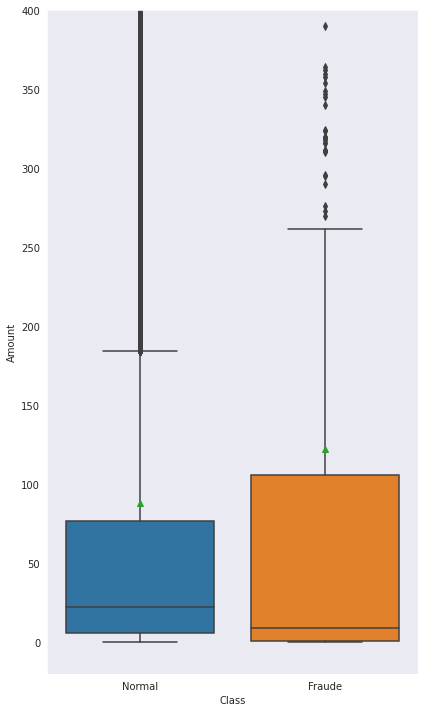

In [9]:
# plotando um boxplot para a dimensão Amount
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 400))
plt.xticks([0,1], ['Normal', 'Fraude'])

plt.tight_layout()

As informações estatísticas para `df.Class ==1`(classe das transações fraudulentas) mostram que sua média está em 118.13 e a mediana em 9.21.

In [19]:
df[(df.Class ==1) & (df.Amount < 2000)]["Amount"].describe()

count     491.000000
mean      118.130550
std       240.439028
min         0.000000
25%         1.000000
50%         9.210000
75%       105.350000
max      1809.680000
Name: Amount, dtype: float64

Com o gráfico de densidade podemos comparar as distribuições das variáveis para cada classe afim de encontrar anomalias.

O que procuramos nesse tipo de visualização são distribuições que diferem uma da outras, podendo identificar fraudes com maior facilidade. Veja por exemplo as variáveis `v3`,` v4`, `v10` e `v11`, como elas estão bem distintas, o que provavelmente será levado em consideração para nosso modelo de *Machine Learning*.

Por outro lado, variáveis como `v8`, `v13` e `v15` são bem similares, apresentado aproximadamente o mesmo comportamento.

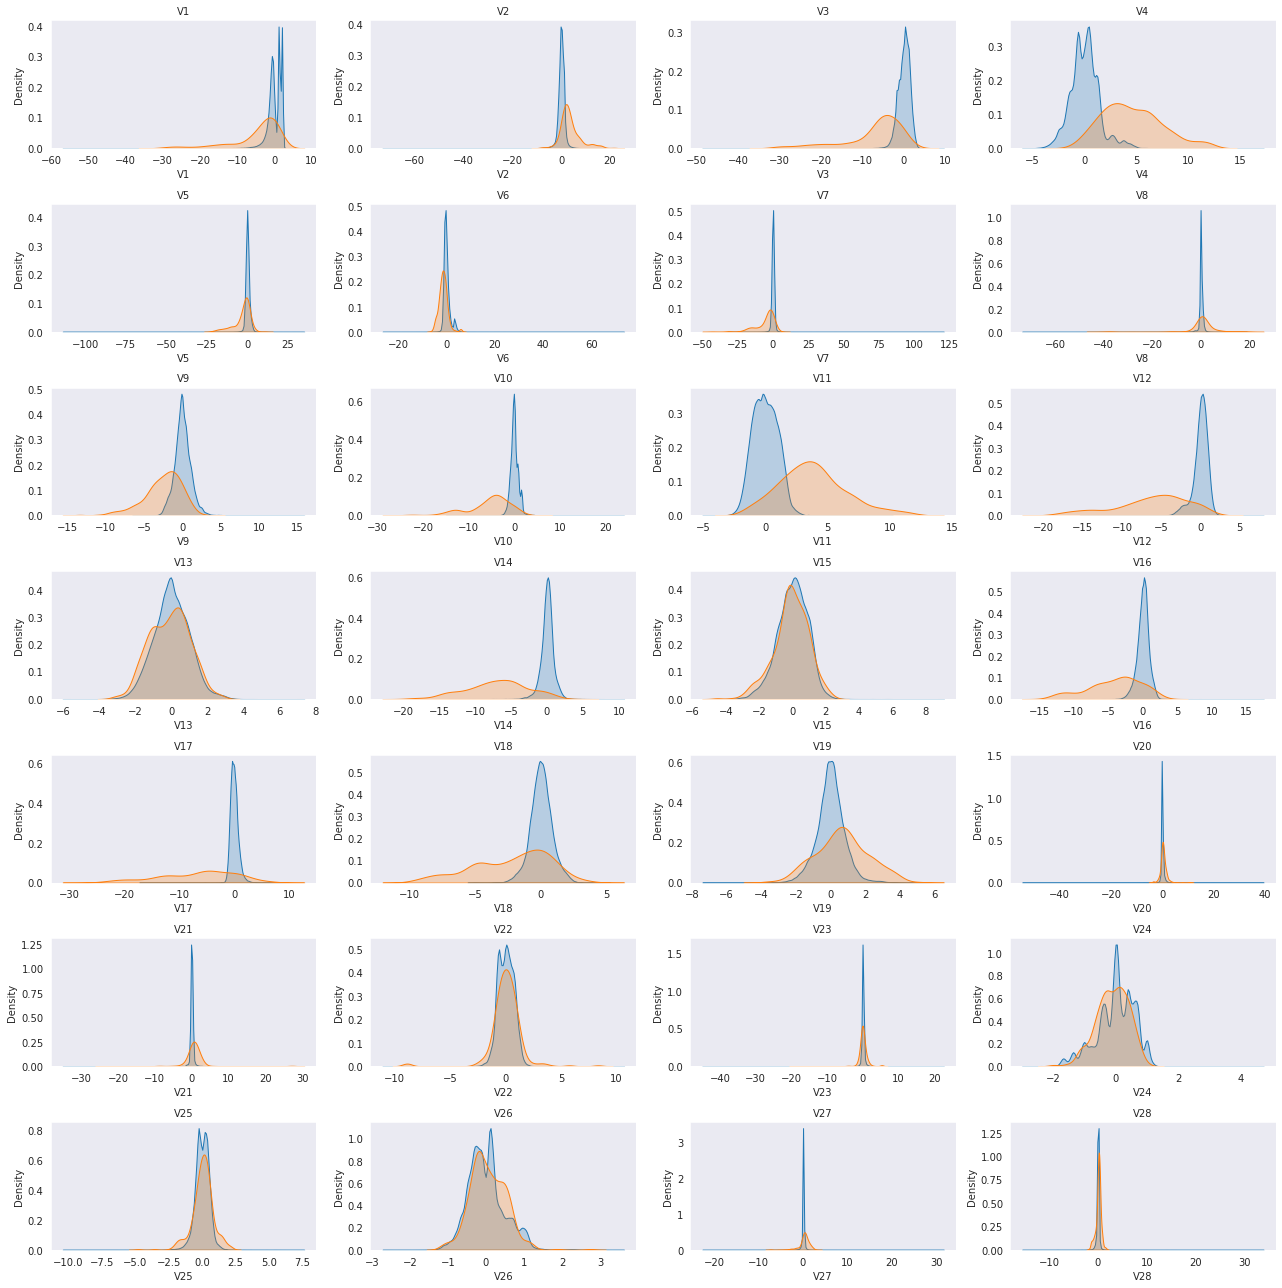

In [10]:
# plotando gráfico de densidade
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plot = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0 
for col in column_names:  
  idx += 1
  plt.subplot(7, 4, idx)
  sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
  sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
  plt.title(col, fontsize=10)

plt.tight_layout()

# Preparando os dados

**Padronizar `Time` e `Amount`**

As colunas `Amount` e `Time` necessitam de padronização pois possuem outliers, utilizaremos a classe `StandardScaler` para isso.

In [11]:
# padronizando as colunas Time e Amount
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1,1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1,1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

**Dividindo entre conjuntos de treino e teste**

Ao prosseguir com nosso balanceamento de dados, precisamos splitar os dados existentes entre treino e teste para que disponhamos de parâmetros para conferir se o balanceamento foi adequado.

Utilizaremos `stratify=True` para que os conjuntos de treino e teste possuam a mesma quantidade de classes proporcionalmente.

In [12]:
# separar variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df['Class']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)


**Balanceamento dos dados**

Usando a biblioteca `imblearn` aplicaremos o balanceamento necessário em nosso conjunto de dados. Nesse caso usaremos o *Under-sampling*, preservando a classe minoritária.

Abaixo podemos ver que nao há mais aquela discrepância inicial do gráfico em barras visto mais acima neste notebook.

1    369
0    369
dtype: int64


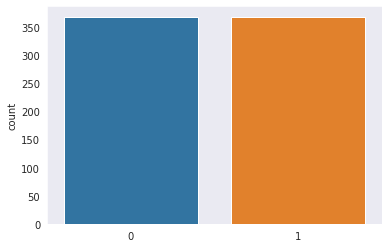

In [13]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_rus);

Podemos ver agora com os dados balanceados a correlação entre as variaveis.
Anteriormente ao balanceamento, a matriz de correlação não apresentava nenhuma informação relevante.

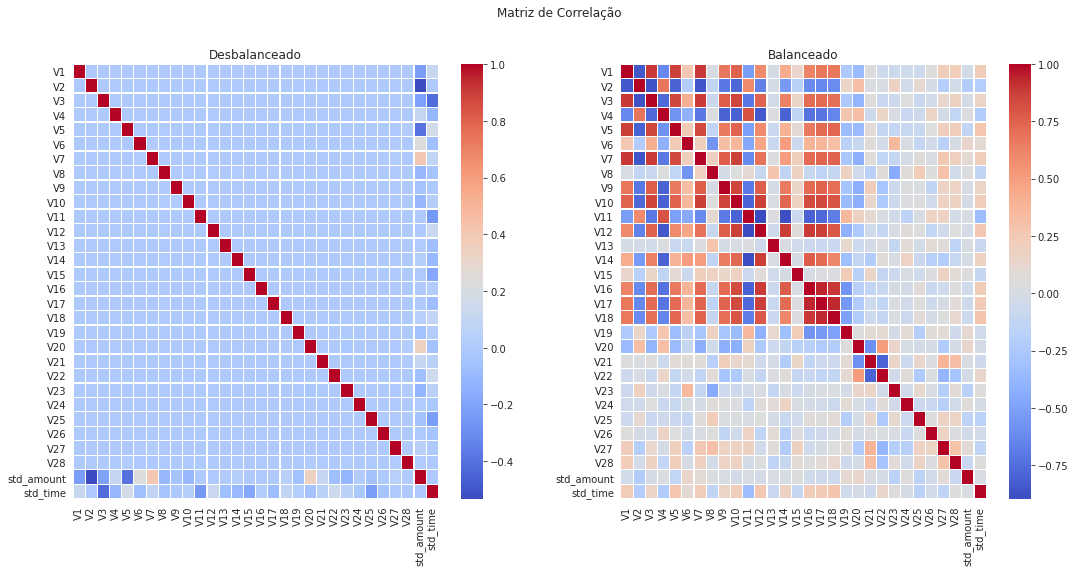

In [14]:
# plotar a matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap='coolwarm', ax=ax[0])
ax[0].set_title("Desbalanceado")

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()


## Modelo de Machine Learning

Após a análise exploratória dos dados e prepará-los, iremos construir um classificador usando uma Árvore de Decisão.

Depois de instanciar o modelo, o mesmo será treinado em cima dos dados em `X_rus` e `y_rus`. E na sequência, serão realizados previsões sobre os dados do teste.

In [15]:
# Instanciar e escolher os hyperparameters
model = DecisionTreeClassifier(max_depth=4, criterion='entropy')

# Fit do modelo(treinar)
model.fit(X_rus, y_rus)

# Fazer previsões em cima dos novos dados
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)


Com o modelo treinado e as revisões feitas, partimos para a avaliação de desempenho.

Como nosso conjunto de dados é originalmente desbalanceado, a acurácia não é a melhor métrica a ser avaliada, visto que em situações como esse, mesmo com uma acurácia de 99,88% podemos detectar menos de 60% das fraudes.

Podemos observar a matriz de confusão para ver a taxa de acertos em transações fraudulentas, ou pela coluna *recall* do Relatório de Classificação.

Outra métrica para avaliar a eficácia do modelo é a AUC ROC, onde obteve 92% de AUC.

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9473    0.9728     71079
           1     0.0285    0.8943    0.0552       123

    accuracy                         0.9472     71202
   macro avg     0.5142    0.9208    0.5140     71202
weighted avg     0.9981    0.9472    0.9712     71202

Acurácia: 0.9472

AUC: 0.9208



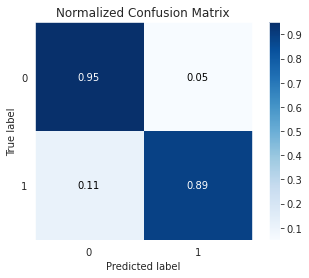

In [16]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# imprimir relatório de classificação
print('Relatório de classificação:\n', classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print('Acurácia: {:.4f}\n'.format(accuracy_score(y_test, y_pred)))

# imprimir a área sob da curva
print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred)))

Como curiosidade podemos ver também como ficou nossa árvore de decisão, verificando os critérios utilizados pelo nosso modelo de classificação criando um dot e desenhando ele abaixo.

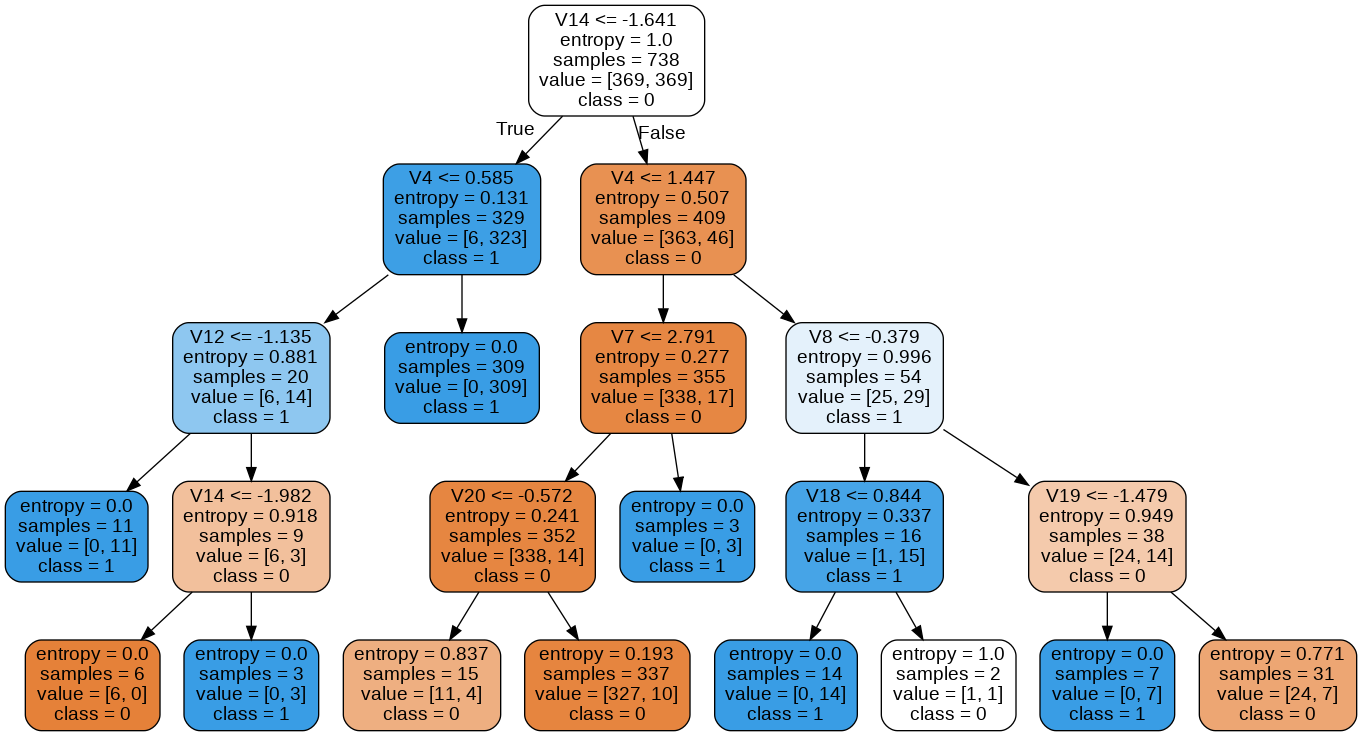

In [18]:
# criando DOT
dot = export_graphviz(model, filled=True, rounded=True,
                      feature_names=X.columns, class_names=['0', '1'])

#plotar
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())

## Conclusões

Mesmo com dados bem tratados, limpos e sem valores ausentes, o desbalanceamento e a transformação PCA exigiram bastante trabalho para interpretação e categorização.

Como dito antes, mesmo com o balanceamento, a discrepância inicial pode afetar nosso modelo de classificação.
Apesar do bom resultado final, podemos usar outros algoritmos de *Machine Learning* afim de otimizar os resultados.

